# Gambler's problem

In [2]:
import numba
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit
from numba import float64, int64

In [3]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Value iteration

The value iteration algorithm is given by following the following update rule:

$$
\begin{aligned}
    v_{k+1}(s) :&= \max_a \mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1}) \vert S_t = s, A_t=a]\\
    &= \max_a\sum_{s', r}p(s', r \vert s, a)\left[r + \gamma v_k(s')\right]
\end{aligned}
$$

* For arbitrary $v_0$, the sequence $v_1, v_2, \ldots$ can be shown to converge to $v_*$ under the same conditions that guarantee the existence of $v_*$ using the policy iteration algorithm.

### Policy improvement
Compare the **value iteration** algorithm to the **policy iteration** algorithm which first tries to find the value function given a policy $\pi$. That is, we try to find $\forall s\in\mathcal{S}.v_\pi(s)$ such that

$$
    v_\pi(s) = \sum_{a} \pi(a\vert s) \sum_{s', r} p(s', r \vert s, a)\left[r + \gamma v_\pi(s')\right] \ \forall s \in \mathcal{S}.
$$

After finding an optimal set of value functions $v_{\pi}(s)$, we *improve* the policy greedily instantiating a new policy $\pi'$ such that

$$
    \pi'(s) = \text{argmax}_a \sum_{s', r} p(s', r \vert s, a)[r + \gamma v_\pi(s)] \ \forall s \in \mathcal{S}.
$$

# The gambler's problem

* A gambler can make bets on a sequence of coins tosses. The probability of heads is given by $p_h$
* Before each toss the gambler decides how much to risk. If the coin lands heads, the gambler wins as many dollars as he has risked on that flip; if it is tail, he loses his stake.
* The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money.

## The setup

* The set of states is the gambler's capital: $\mathcal S = \{1, 2, \ldots, 99\}$
* The set of actions, given a state, are the stakes: $\mathcal{A}_{s} = \{0, 1, \ldots, \min(s, 100 - s)\}$

$$
\begin{aligned}
    \mathbb{P}(S_t=s', R_t=r \vert S_{t-1}=s, A_t=a) &= \mathbb{P}(S_t=s'\vert S_{t-1}=s, A_t=a)\mathbb{P}(R_t=r \vert S_{t}=s')\\
    &= \mathbb{P}(S_t=s'\vert S_{t-1}=s, A_t=a) \mathbb{1}(s' = 100)
\end{aligned}
$$

For every state $s \in \{0,1, 2, \ldots, 98\}$,

$$
\begin{aligned}
    p(s + a, 0, \vert s, a) &= p_h\\
    p(s - a, 0, \vert s, a) &=1  - p_h\\
\end{aligned}
$$

In the special case where $s=99$,

\begin{aligned}
    p(s + a, 1, \vert s, a) &= p_h\\
    p(s - a, 0, \vert s, a) &=1  - p_h\\
\end{aligned}

In [175]:
max_capital = 100
p_heads = 0.4

### Set of actions
Action upper bound as a function of the capital.
Note that the triangular form is due to the constraint of being able to stake at most 100.

In [397]:
@njit(float64(int64, int64, int64, int64, float64))
def pr_mdp(new_capital, reward, capital, stake, p_heads):
    """
    Markov decision process
    P(s', r | s, a)
    """
    # Either we earn as much as we risked or lose our stakes
    proba = p_heads * (new_capital == capital + stake) + (1 - p_heads) * (new_capital == capital - stake)
    
    # Either the reward is zero, and the new capital is in the range [0, 100),
    # or the reward is one, but we reach the terminal state.
    valid_reward = (
        (reward == 0) * (new_capital < max_capital) * (new_capital >= 0) +
        (reward == 1) * (new_capital == max_capital)
    )
    
    # 
    valid_stakes = stake <= np.minimum(capital, max_capital - capital)
    
    proba = proba * valid_reward * valid_stakes
    proba = (
        proba * (capital < max_capital) * (capital > 0) * (stake > 0)
        ## Absorbing states
        + (capital == max_capital) * (new_capital == max_capital) * (reward == 0)
        + (capital == 0) * (new_capital == 0) * (reward == 0)
         # Probabilty of staying in the same state (not needed?)
         + 0 * (stake == 0) * (reward == 0) * (capital == new_capital) * (capital < max_capital) * (capital > 0)

    )
    
    return proba


@njit(float64(int64, int64, float64[:], float64, float64))
def action_value_function(capital, stakes, value_function, discount, pr_heads):
    new_capital_choices = [capital + stakes, capital - stakes]
    new_capital_choices = np.arange(capital - stakes, capital + stakes + 1)
    
    vpi = 0.0
    reward_range = [0.0, 1.0]
    for new_capital in new_capital_choices:
        for reward in reward_range:
            vfprime = value_function[new_capital]
            vpi += pr_mdp(new_capital, reward, capital, stakes, pr_heads) * (reward + discount * vfprime)
    return vpi


@njit
def single_value_function(capital, value_function, discount, pr_heads):
    max_allowed_stakes = np.minimum(capital, max_capital - capital)
    stakes = np.arange(max_allowed_stakes + 1)
    
    v_max, stake_max = -1.0, -1
    
    digits = 6
    for stake in stakes:
        v_action = action_value_function(capital, stake, value_function, discount, pr_heads)
        if np.round(v_action, digits) > np.round(v_max, digits):
            v_max = v_action
            stake_max = stake
    
    return v_action, stake_max


@njit(parallel=True)
def compute_value_function(value_function, discount, pr_heads):
    nstates = len(capital_range)
    
    new_value_function = np.zeros(nstates)
    policy = np.zeros(nstates)
    
    for i in numba.prange(nstates):
        capital = capital_range[i]
        vpi, stake_max = single_value_function(capital, value_function, discount, pr_heads)
        new_value_function[i] = vpi
        policy[i] = stake_max
    
    return new_value_function, policy

@njit
def value_iteration(value_function, pr_heads, discount=1.0, tol=1e-6, store_values=False):
    delta = 0.0
    delta_values = []
    value_functions = [value_function]
    converge = False
    
    while not converge:
        value_function_new, policy = compute_value_function(value_function, discount, pr_heads)
        delta = np.abs(value_function_new - value_function).max()
        value_function = value_function_new
        delta_values.append(delta)
        
        if store_values:
            value_functions.append(value_function)
        
        if delta <= tol:
            converge = True
        
    delta_values = np.array(delta_values)
    return value_function, policy, delta_values, value_functions

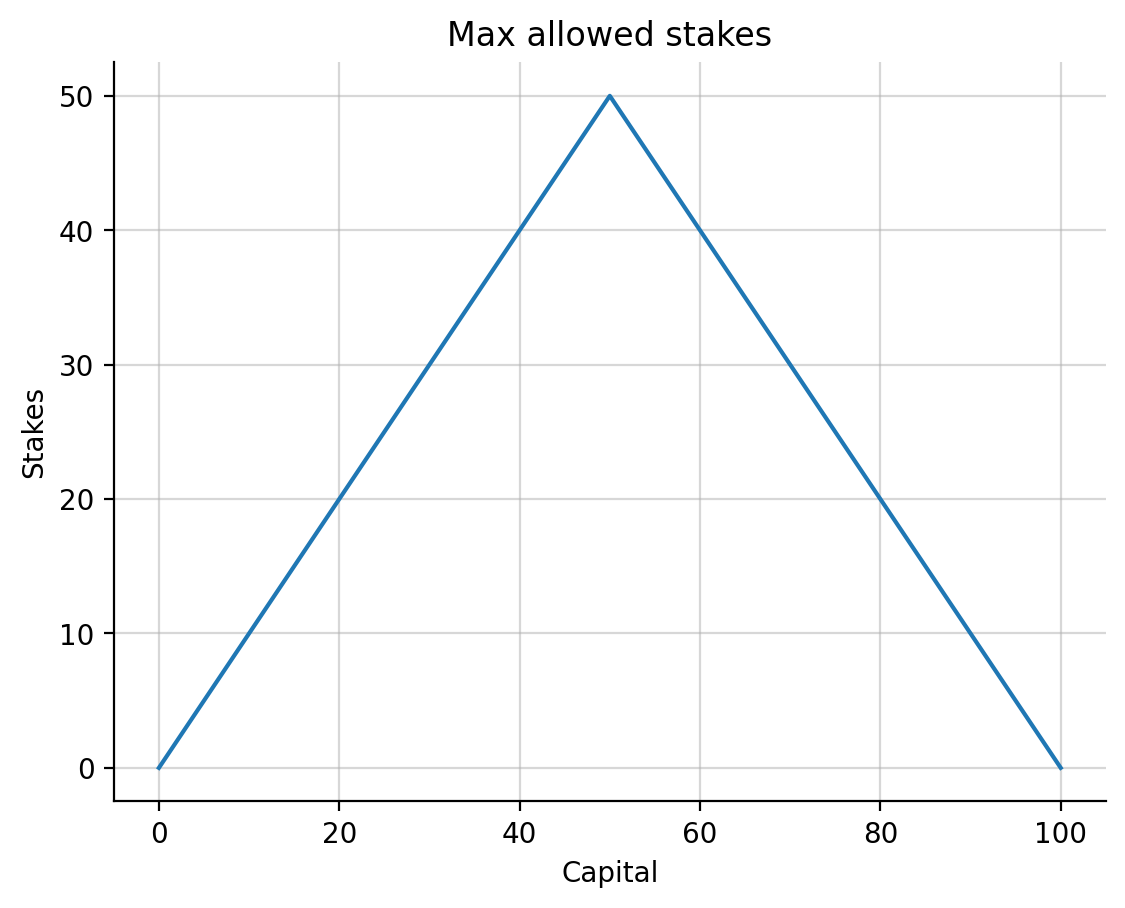

In [398]:
capital_range = np.arange(0, 101)
actions = np.minimum(capital_range, 100 - capital_range)
plt.plot(capital_range, actions)

plt.title("Max allowed stakes")
plt.xlabel("Capital")
plt.ylabel("Stakes")
plt.grid(alpha=0.5)

In [486]:
discount = 1.0
capital_range = np.arange(max_capital + 1)
# capital_range = np.arange(1, max_capital)
stakes_range = np.arange(max_capital // 2 + 1) # stakes begin at 1?

value_function = np.zeros_like(capital_range).astype(float)
value_function[-1] = 1

pr_heads = 0.49
res = value_iteration(value_function, pr_heads, tol=1e-20, store_values=True)
value_function, policy, delta_values, value_functions = res

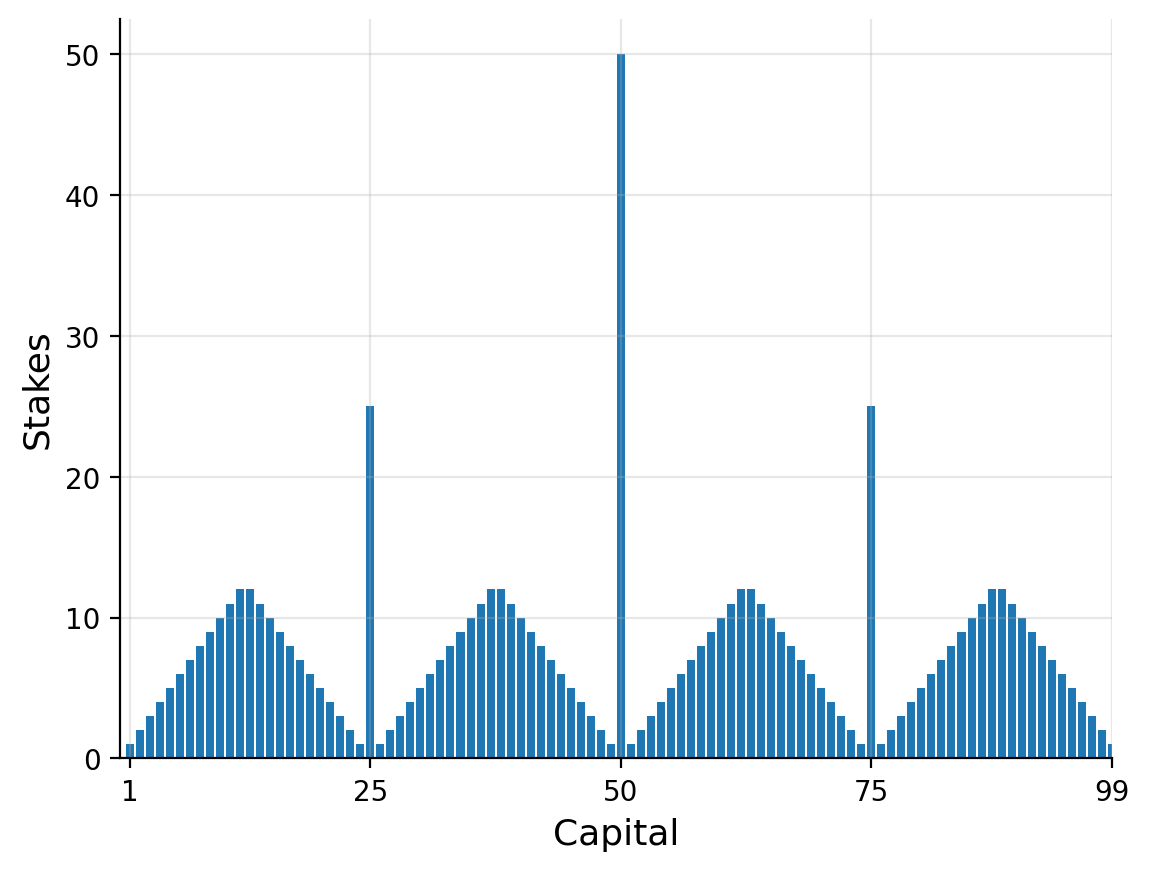

In [487]:
plt.bar(capital_range, policy)
plt.xlim(0, max_capital-1)
plt.xlabel("Capital", fontsize=13)
plt.ylabel("Stakes", fontsize=13)
plt.xticks([1, 25, 50, 75, 99])
plt.grid(alpha=0.3)

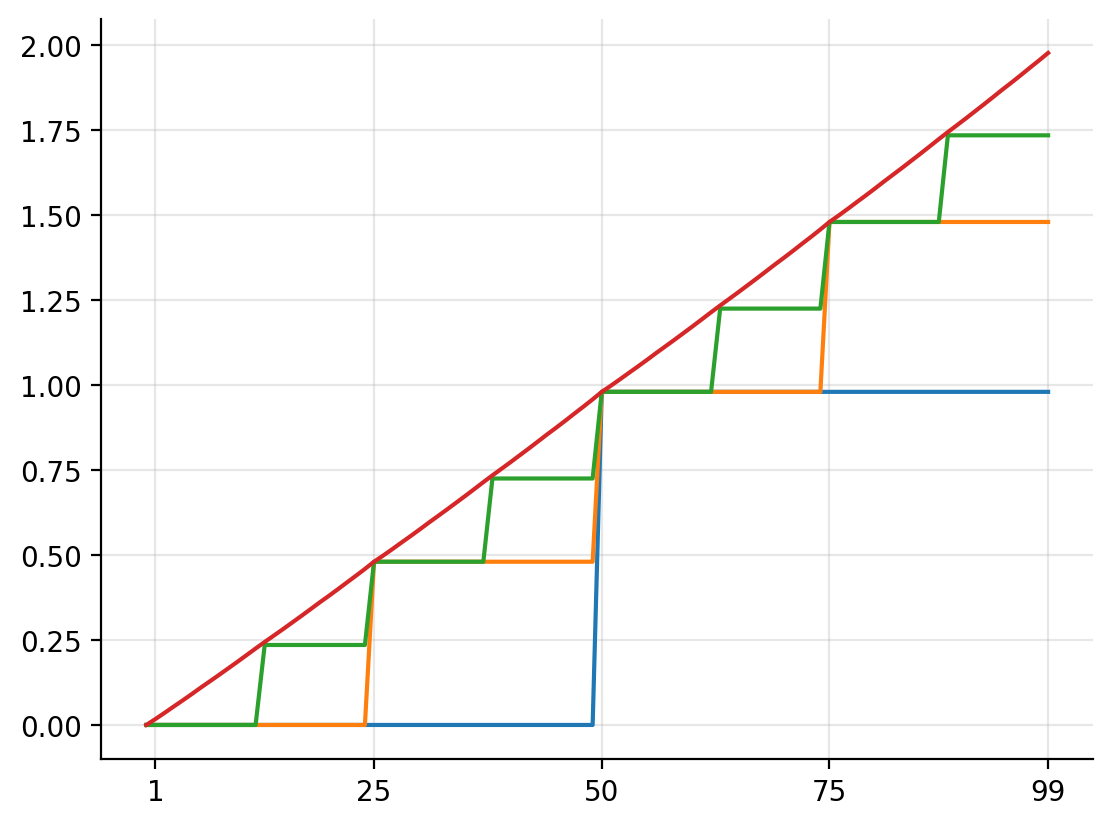

In [488]:
its = [1, 2, 3, -1]
for vf in its:
    plt.plot(capital_range[:-1], value_functions[vf][:-1])
plt.xticks([1, 25, 50, 75, 99])
plt.grid(alpha=0.3);
# plt.ylim(0, 1)

## Some experiments

In [497]:
i = 0

capital = 5
pnl = [capital]
stakes = []

np.random.seed(314)
while capital not in [0, 100]:
    toss = np.random.choice(2, p=[1 - pr_heads, pr_heads])
    stake = policy[capital].astype(int)
    capital = capital + stake * toss + stake * (toss - 1)
    
    pnl.append(capital)
    stakes.append(stake)

In [498]:
stakes

[5, 10, 5, 10, 25, 50]

In [499]:
pnl

[5, 10, 20, 15, 25, 50, 100]

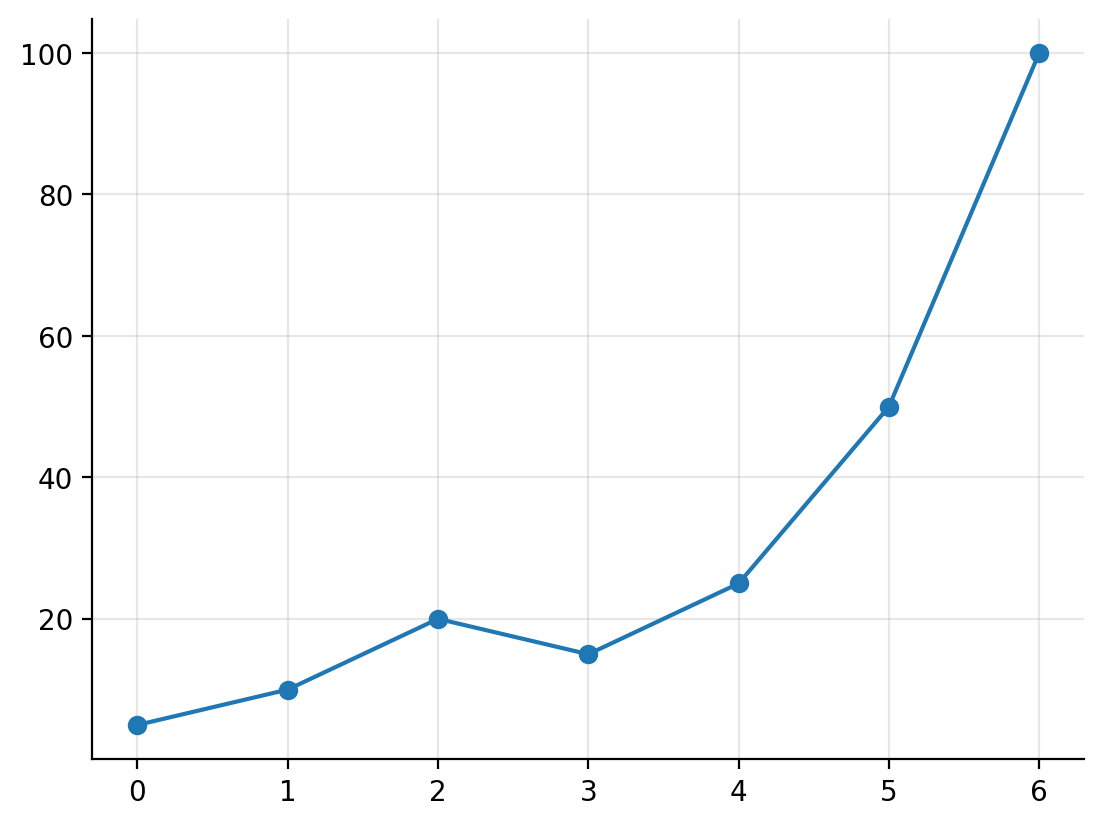

In [500]:
plt.plot(pnl, marker="o")
plt.grid(alpha=0.3)